Testing parallel options:
- with separate DiaObjectLast table used as index for last version of DiaSource
- Storage is SSD (NVMe and SATA)
- FOV is split into rectangular tiles and each tile is processed in separate process
- all database queries are done on per-tile basis

Beacuse there are many things running in parallel it's pointless to compare time per individual query, so here we compare times per whole visit processing


In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

import plots
plots.plot_width = 10

from plots import do_plots, do_plots_all

C:\Users\salnikov\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


MySQL with whole FOV processing (no tiles)
=================================

These numbers is actually from the previous tests, I did not repeat it.

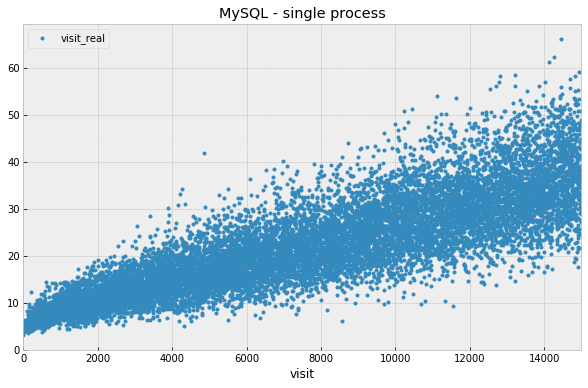

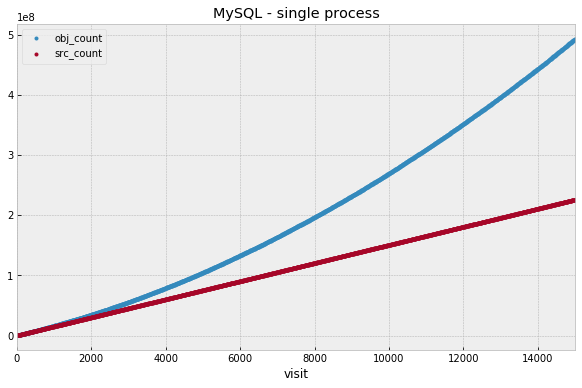

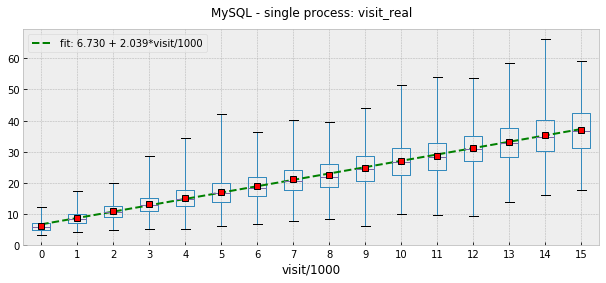

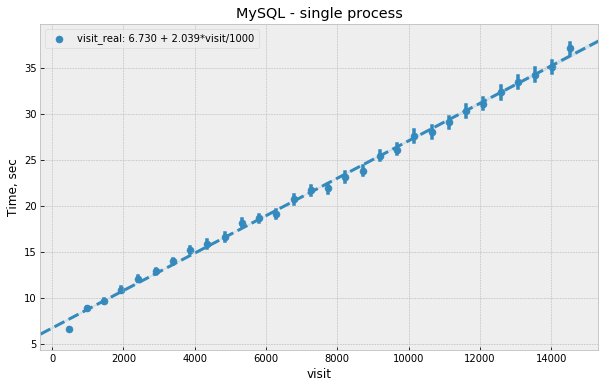

In [2]:
ds = do_plots("data/dm-9301-mysql-no-tiles.csv.gz", "MySQL - single process", bin=1000)

MySQL with 5x5 tiles
=====================================

There was an issue in visit 14439, mysql timed out on many clients with error "Lock wait timeout exceeded".

Processing runs about 4 times faster.

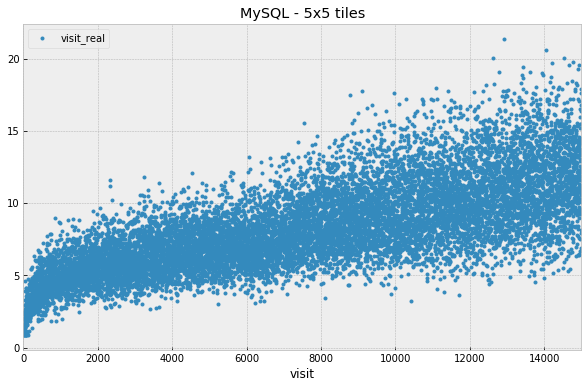

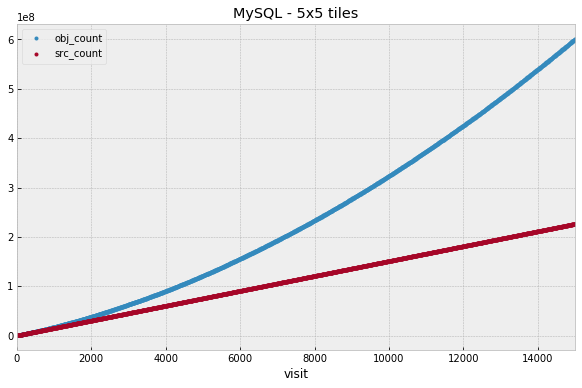

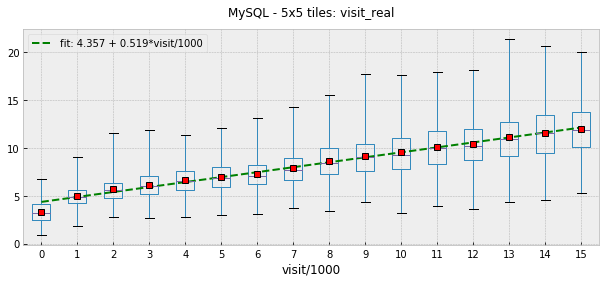

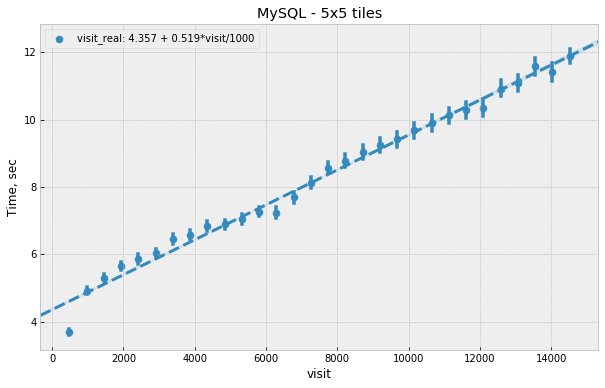

In [3]:
ds = do_plots("data/dm-9301-mysql-5x5.csv.gz", "MySQL - 5x5 tiles", bin=1000, bad_visits=[14439]);

Postgres with whole FOV(no tiles)
==================================

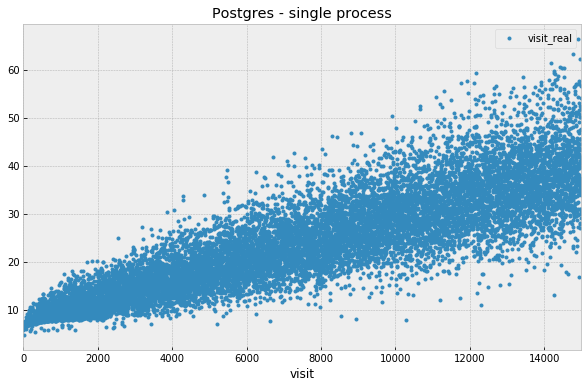

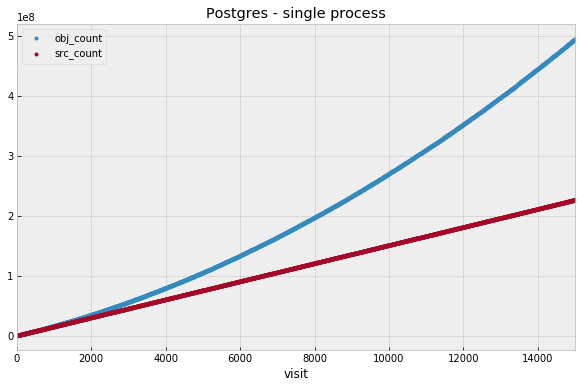

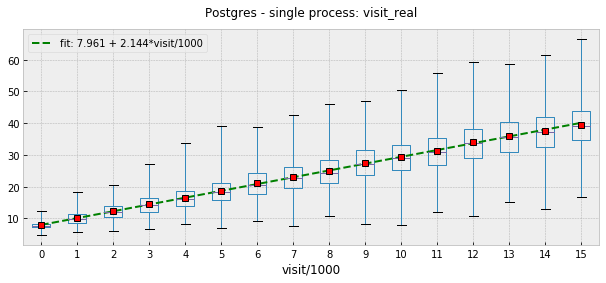

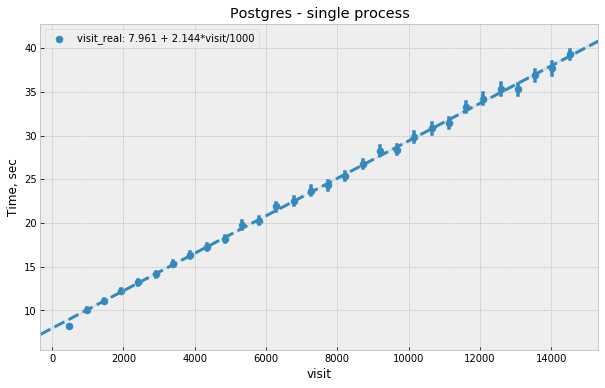

In [4]:
ds = do_plots("data/dm-9301-pg-no-tiles.csv.gz", "Postgres - single process", bin=1000)

Postgres with 5x5 tiles
=======================


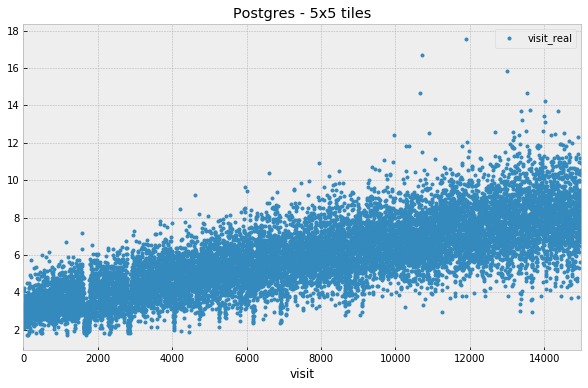

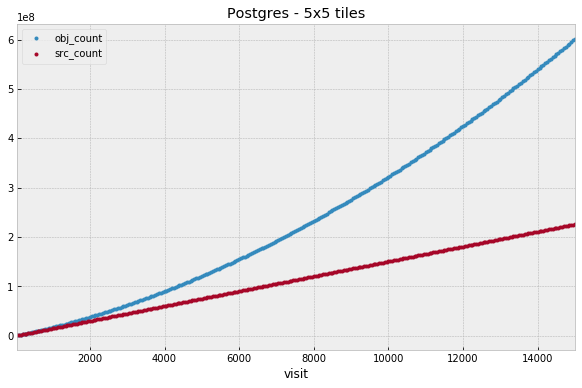

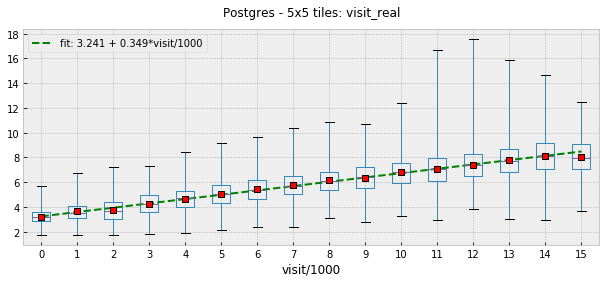

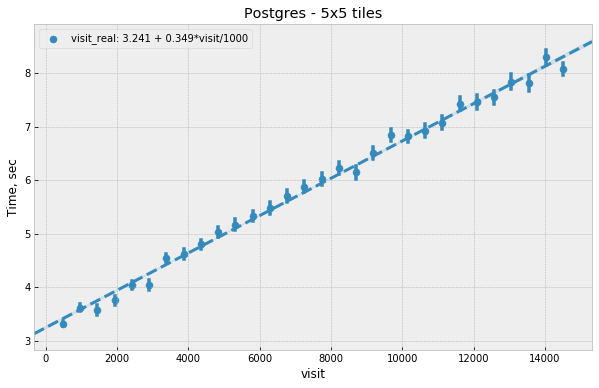

In [5]:
ds = do_plots("data/dm-9301-pg-5x5.csv.gz", "Postgres - 5x5 tiles", bin=1000)

## Postgres with 15x15 tiles (SATA SSD)

I think we observe a SSD "write cliff" after ~11,000 visits. These tests are on SATA SSD storage which is connected as RAID-0 array (made from two 1.6TB SSDs) to a RAID controller.

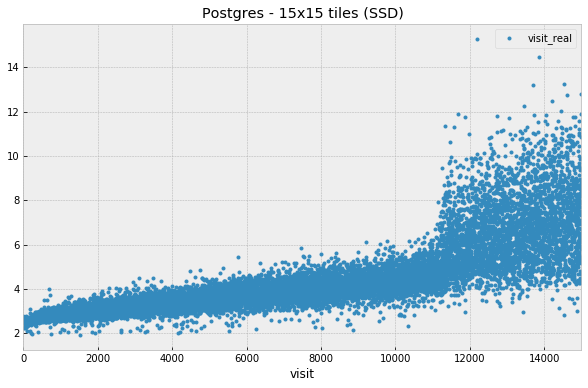

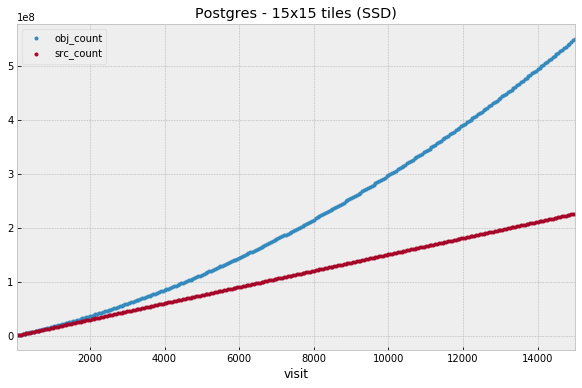

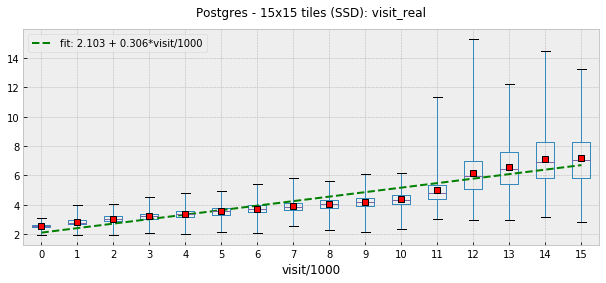

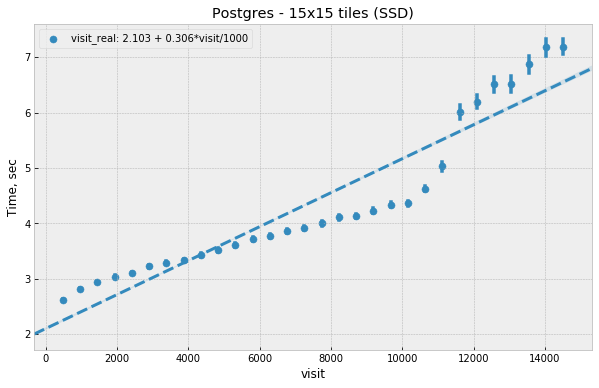

In [6]:
ds = do_plots("data/dm-9301-pg-15x15.csv.gz", "Postgres - 15x15 tiles (SSD)", bin=1000)

Postgres 15x15 after cleanup
===============
This is a repat of the same test (incomplete) after removing few databases from Postgres instance and disabling auto-vacuum. There is still sign of degradation, though this is probably related to disabled auto-vacuum. At visit 1000 "VACUUM" was ran on a database, which improved things a little bit but maybe only temporariliy.

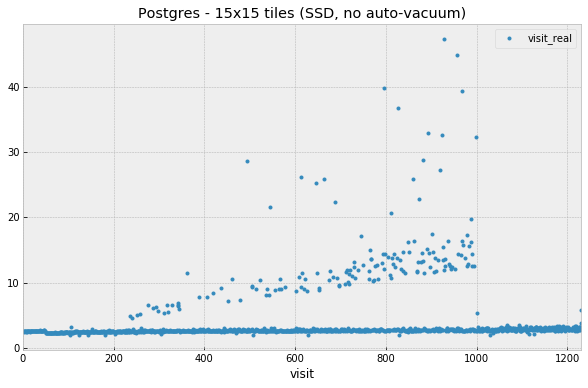

In [7]:
ds = do_plots("data/dm-9301-pg-15x15-02.csv.gz", "Postgres - 15x15 tiles (SSD, no auto-vacuum)", what=['scatter'])

Postgres 15x15 on NVMe
===============

This test is done on NVMe disk, after running `fstrim`. Auto-vacuum is disabled and "VACUUM ANALYZE" runs on every 1000 visits. There is still something weird happening in first 1000 visits, likely this is due to disabled auto-vacuum.

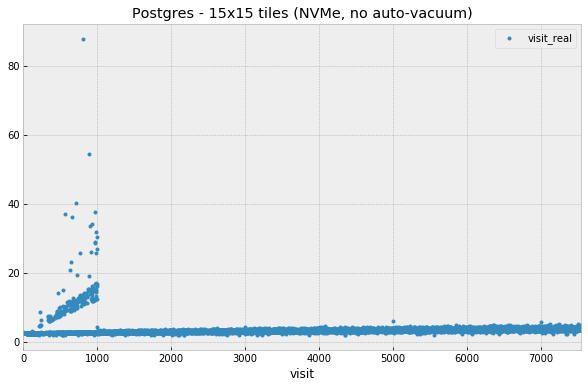

In [8]:
ds = do_plots("data/dm-9301-pg-15x15-03.csv.gz", "Postgres - 15x15 tiles (NVMe, no auto-vacuum)", what='scatter')

Re-enabling auto-vacuuming fixes behavior. There is also manual vacuuming every 1000 visits, no signs that it helps anything.

**NOTE** Plots below show time excluding Source generation time (DIA step of ap_proto) which is small and constant.

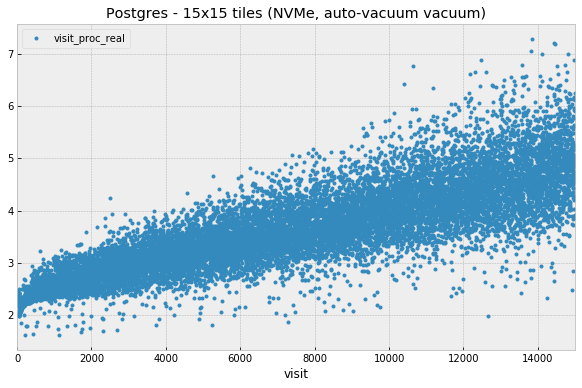

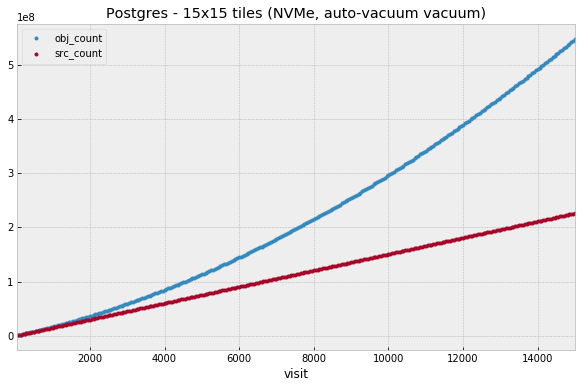

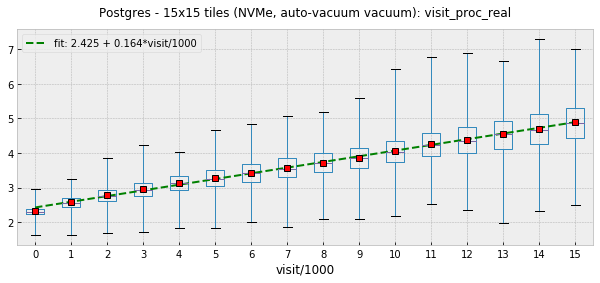

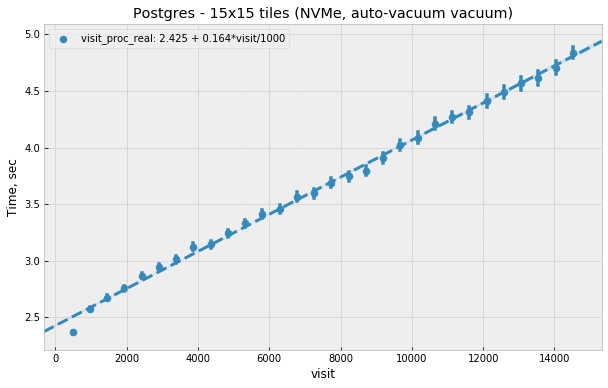

In [9]:
ds = do_plots("data/dm-9301-pg-15x15-nvme-04.csv.gz", "Postgres - 15x15 tiles (NVMe, auto-vacuum vacuum)", 
              bin=1000, time='visit_proc_real')

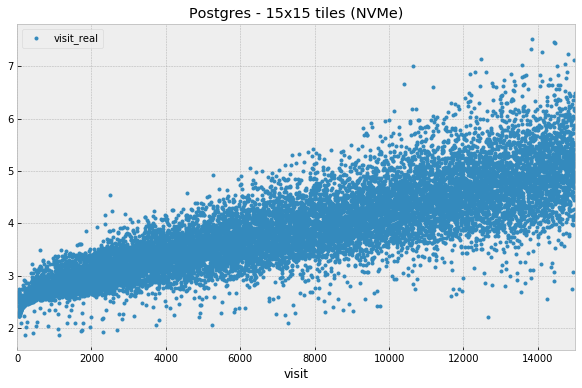

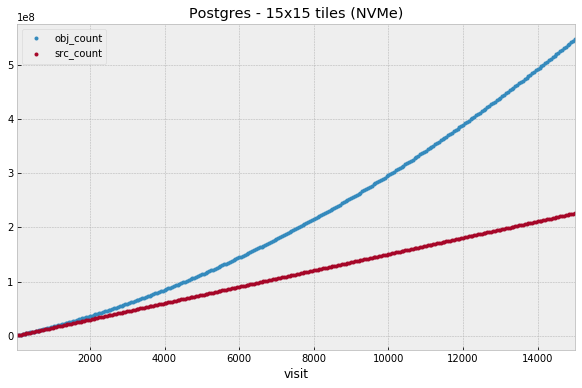

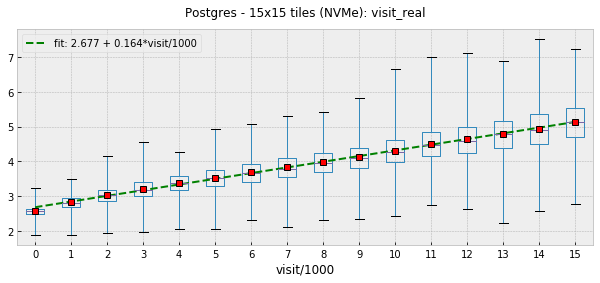

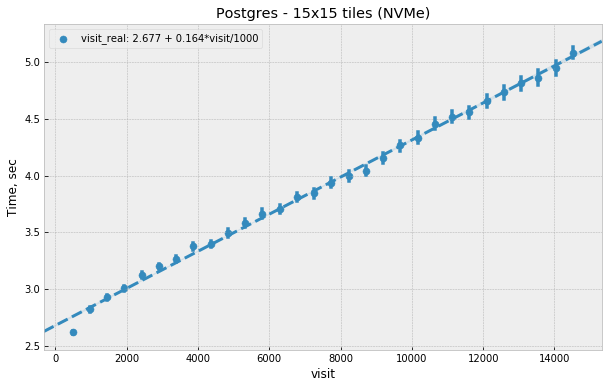

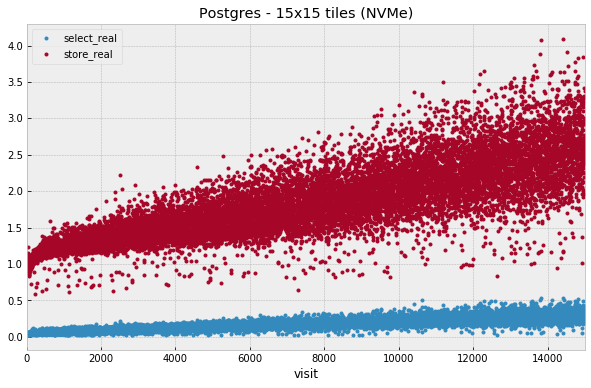

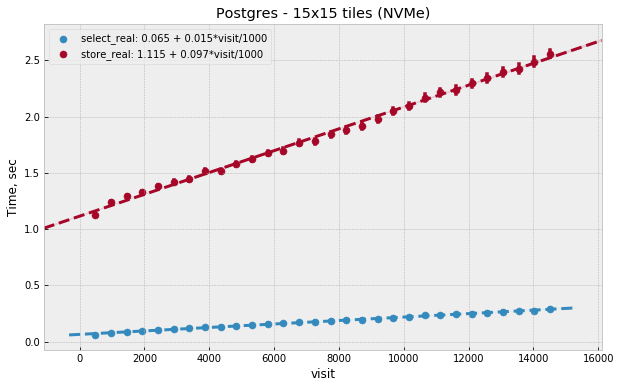

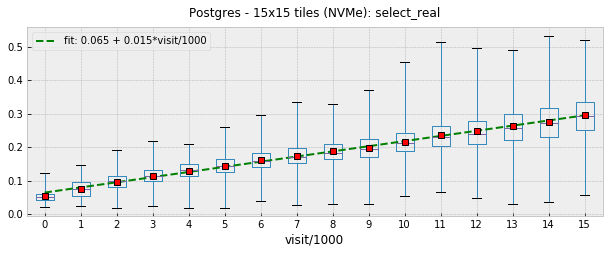

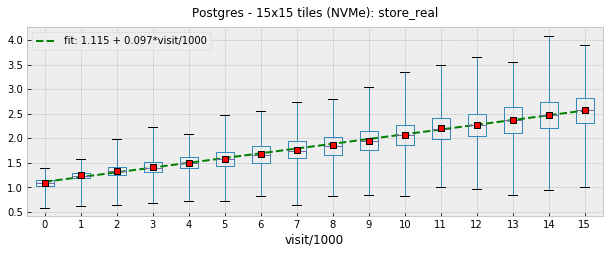

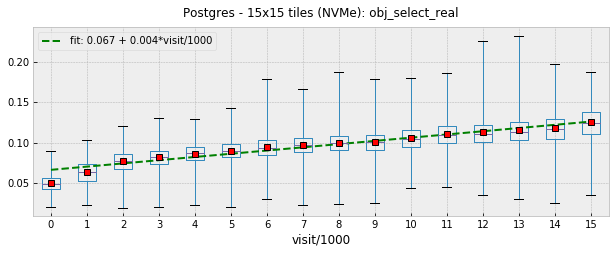

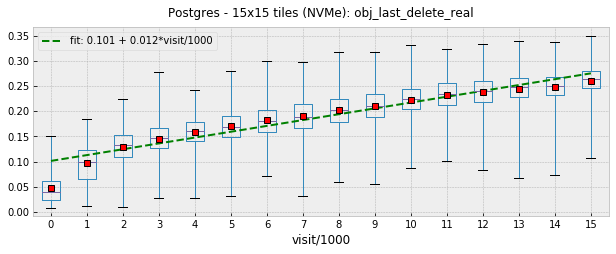

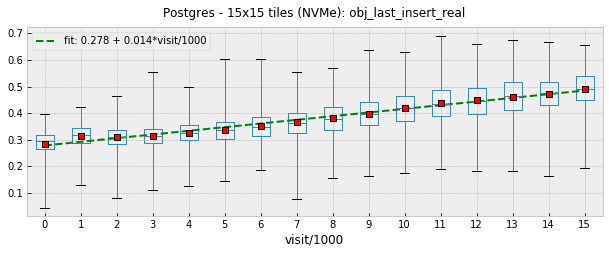

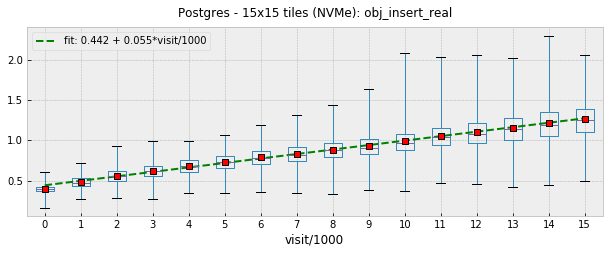

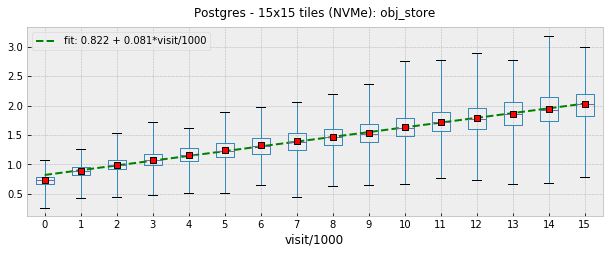

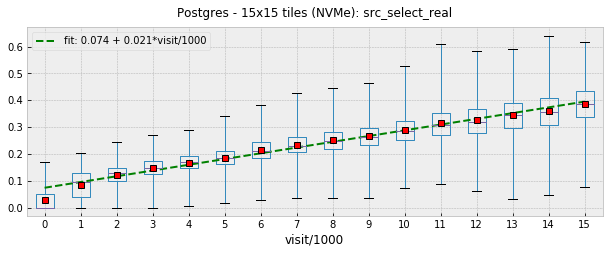

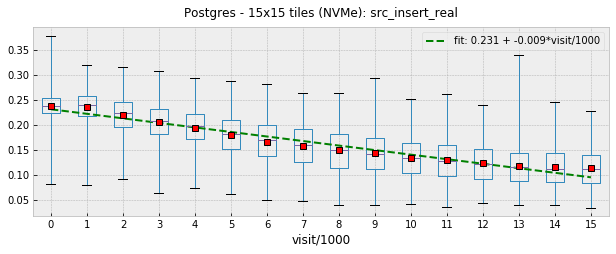

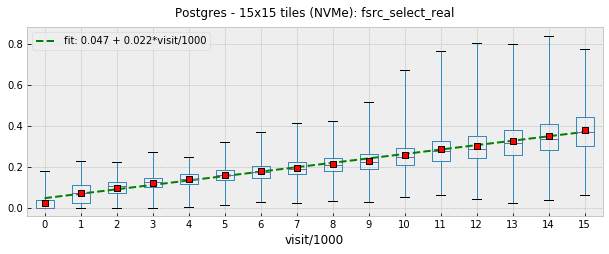

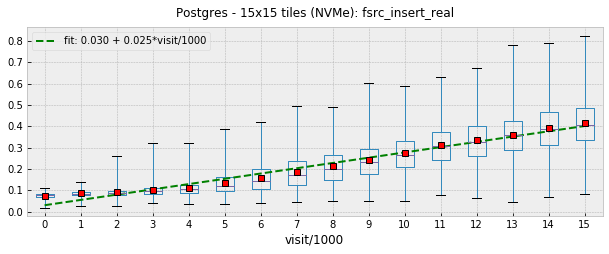

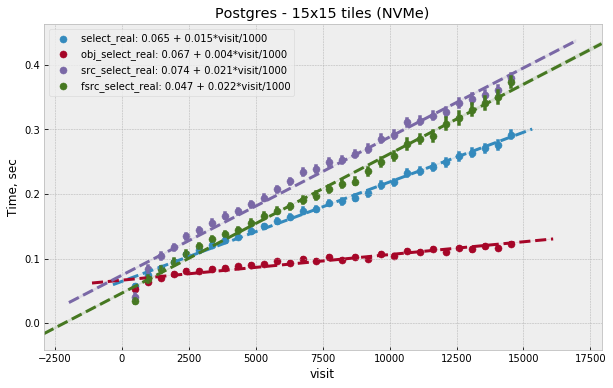

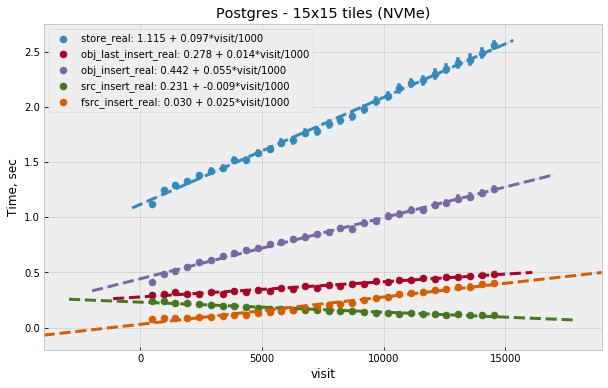

In [10]:
csv = "data/dm-9301-pg-15x15-nvme-04-long.csv.gz"
title = "Postgres - 15x15 tiles (NVMe)"
ds = do_plots(csv, title, bin=1000, filter_count=True)
ds = do_plots_all(csv, title, bin=1000, filter_count=True)

Repeat of the test on SSD, freeing space on disk and enabling auto-vacuum.

Performance is somewhat worse than NVMe, likely NVMe has much better parallelism.

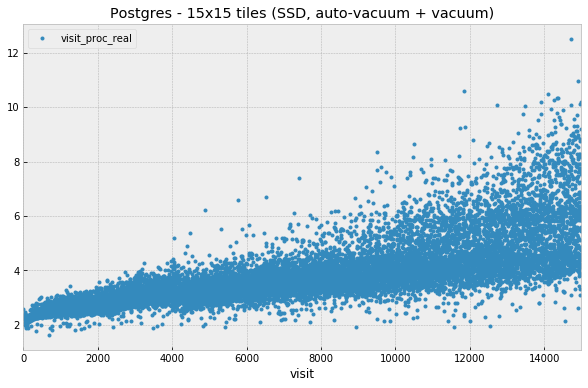

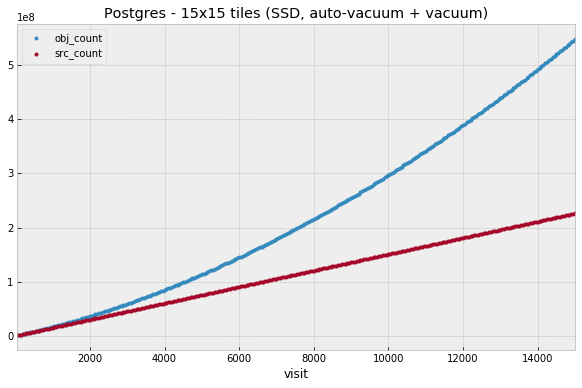

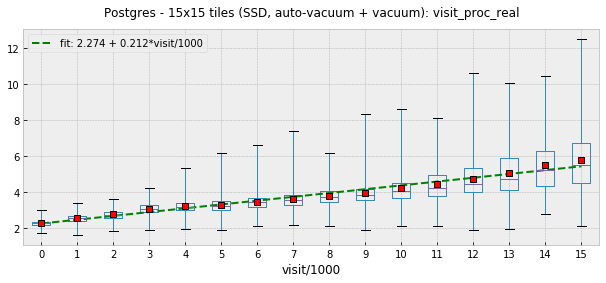

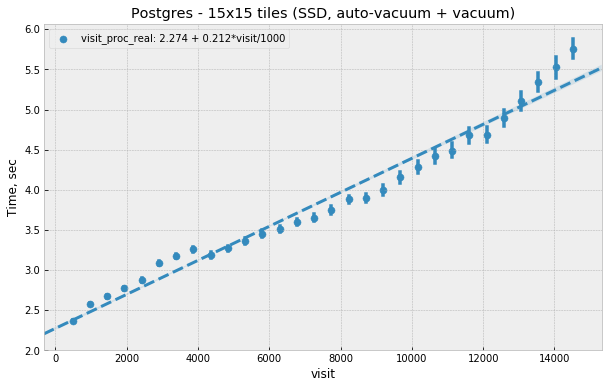

In [11]:
ds = do_plots("data/dm-9301-pg-15x15-ssd-05.csv.gz", "Postgres - 15x15 tiles (SSD, auto-vacuum + vacuum)", 
              bin=1000, time='visit_proc_real')

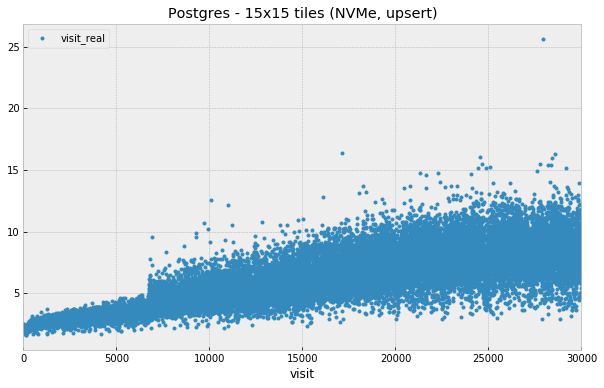

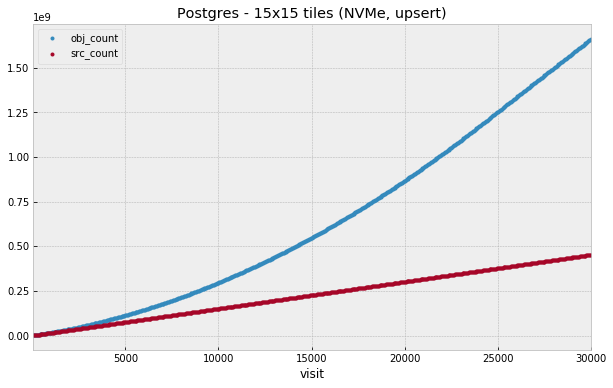

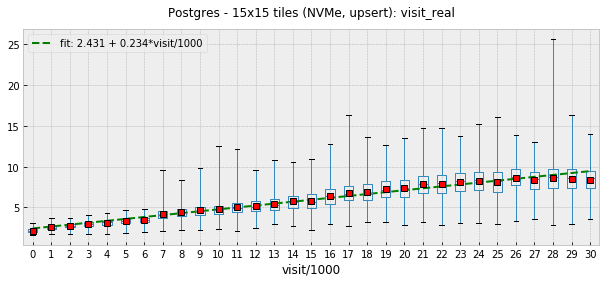

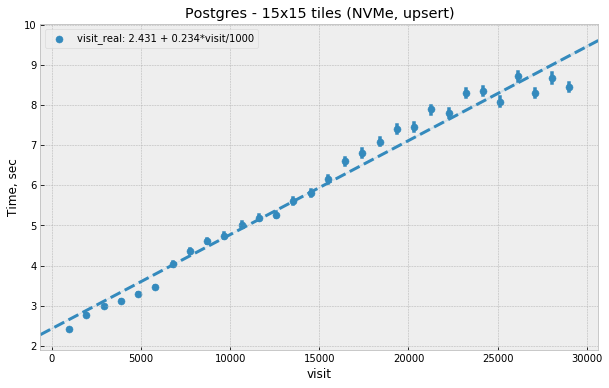

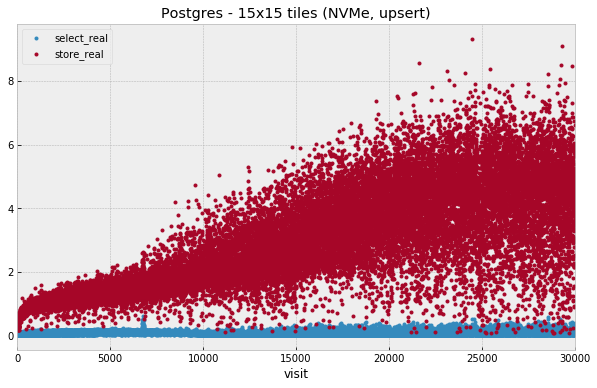

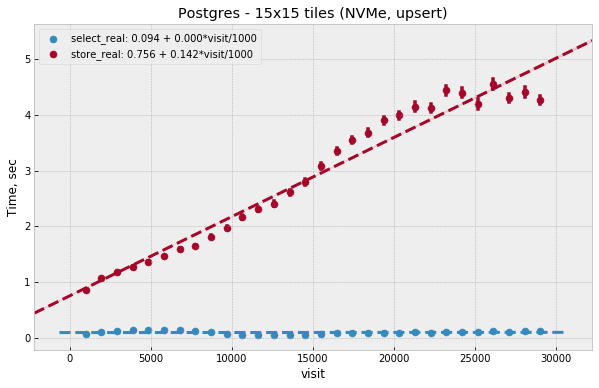

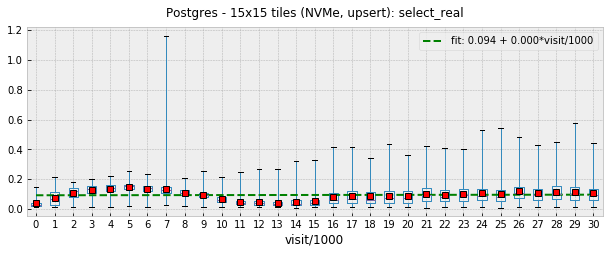

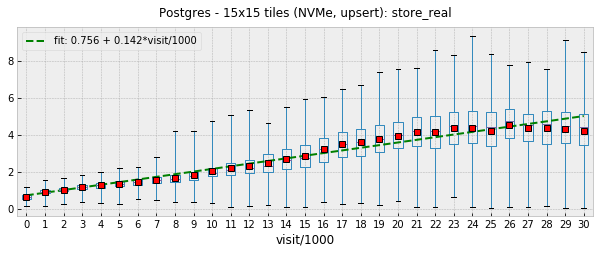

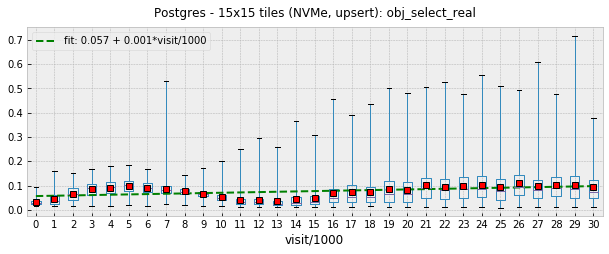

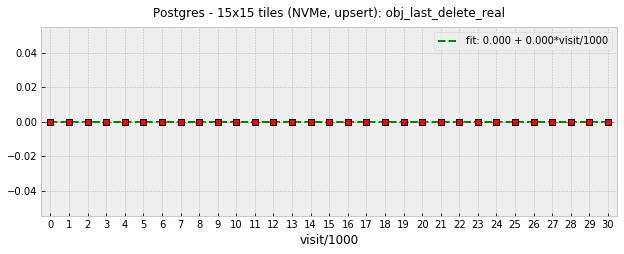

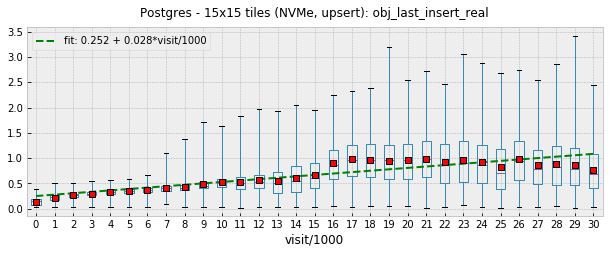

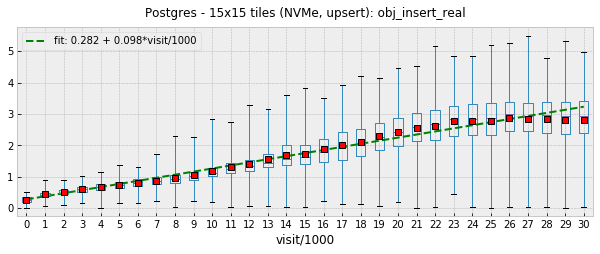

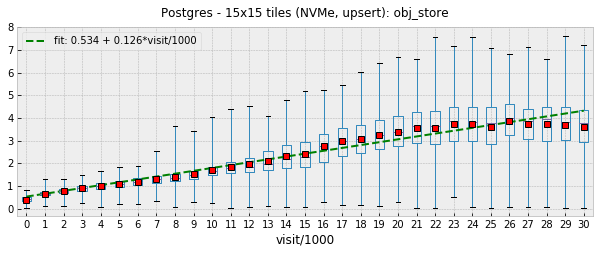

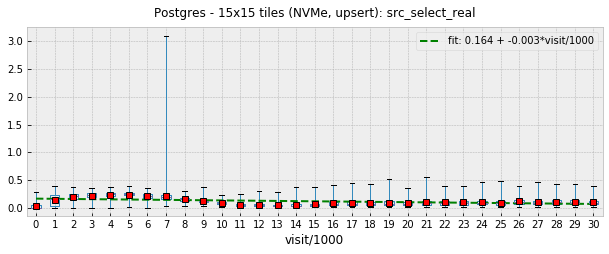

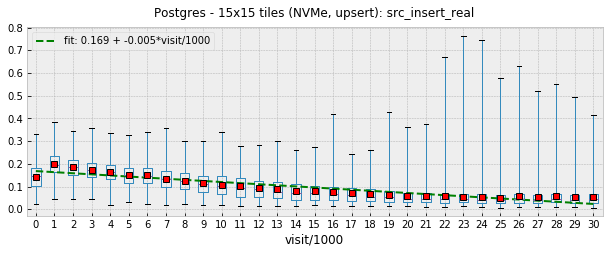

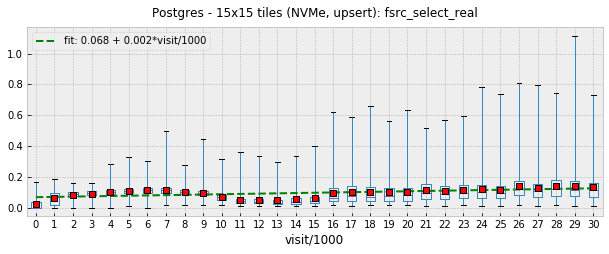

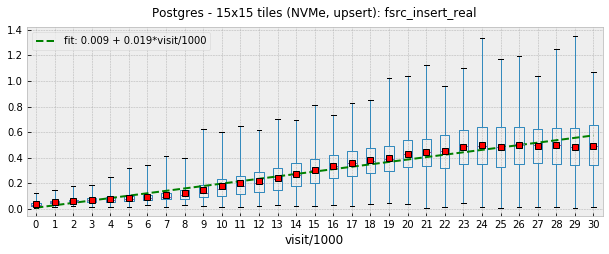

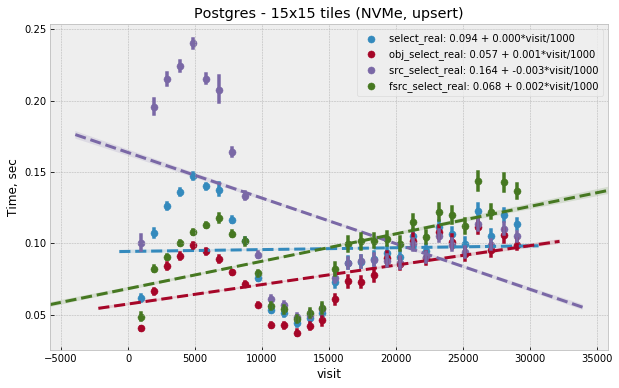

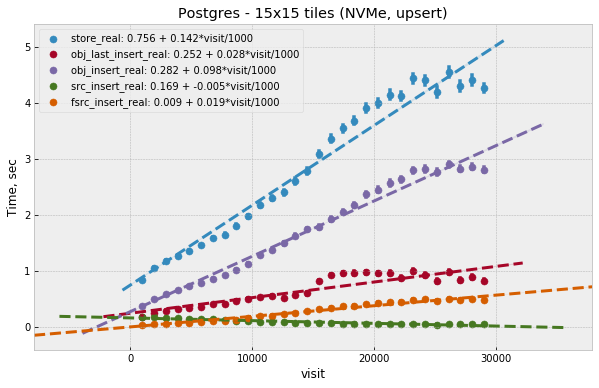

In [12]:
csv = "data/dm-9301-pg-15x15-nvme-upsert-06-long.csv.gz"
title = "Postgres - 15x15 tiles (NVMe, upsert)"
ds = do_plots(csv, title, bin=1000, filter_count=True)
ds = do_plots_all(csv, title, bin=1000, filter_count=True)

MySQL 15x15 on NVMe
==============

Significantly slower as Postgres.

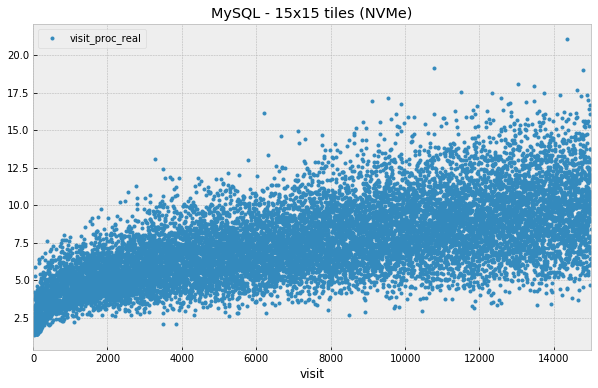

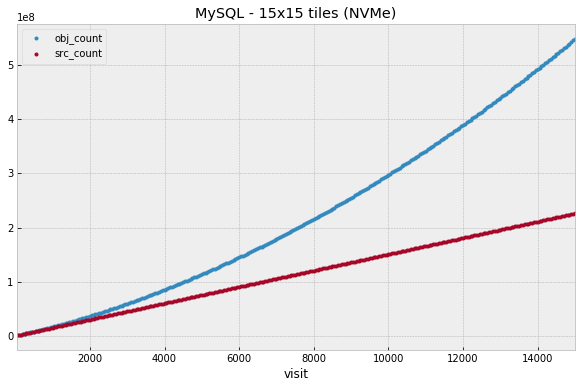

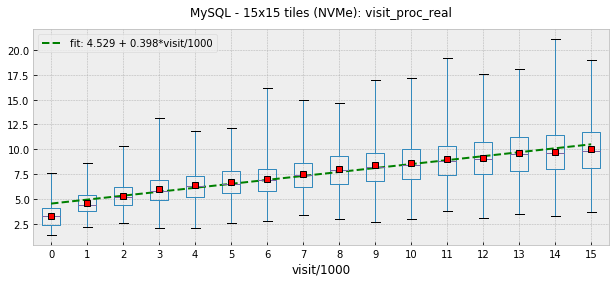

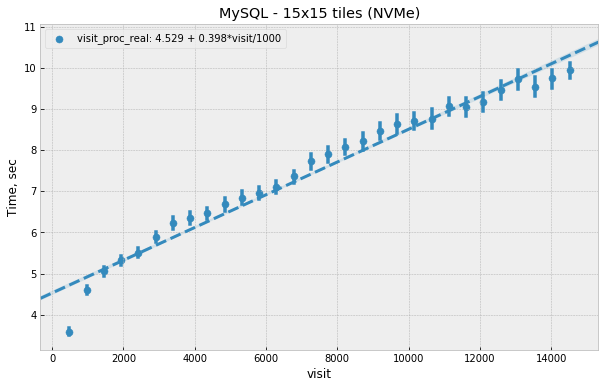

In [13]:
ds = do_plots("data/dm-9301-mysql-15x15-nvme-01.csv.gz", "MySQL - 15x15 tiles (NVMe)",
              bin=1000, time='visit_proc_real');

## MySQL 15x15 on SSD / SATA


A little bit slower than NVMe

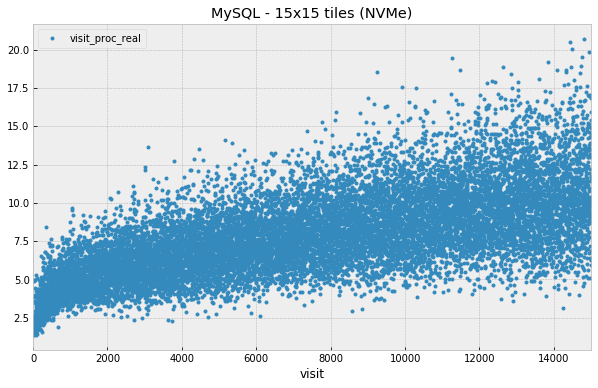

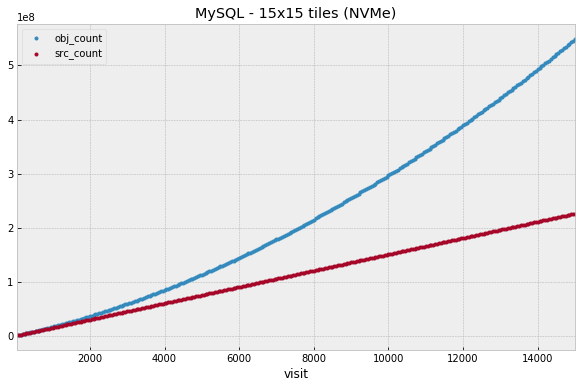

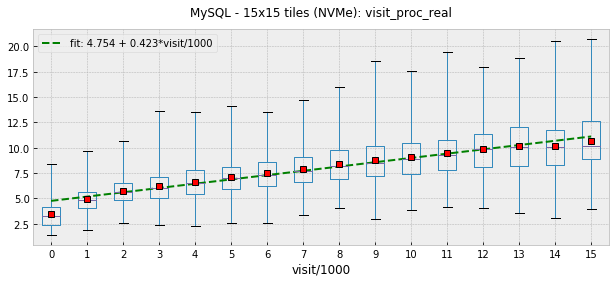

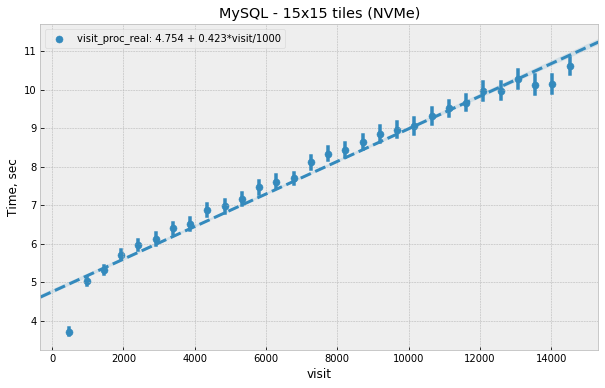

In [14]:
ds = do_plots("data/dm-9301-mysql-15x15-ssd-02.csv.gz", "MySQL - 15x15 tiles (NVMe)",
              bin=1000, time='visit_proc_real');